# Introduction to paleoclimate data assimilation

Paleoclimate data assimilation is a method of reconstructing past climate. It uses proxy records at discrete locations along with covariances from model data to compute a spatially-complete climate field.

This notebook explores some of the equations used in paleoclimate data assimilation. It is not intended to be a full description of the methodology, but explores the heart of the method (the Ensemble Kalman Filter) using a highly simplified example.

## Proxies and models

Paleoclimate data assimilation uses information from two sources:
 - **Proxies**: Point data at different locations
 - **Model data**: A collection of model climate states provide two things: 1) a first estimate of the climate along with uncertainties and 2) it allows us to compute covariances between every location and every other location. This collection of model states is known as the "prior".
 
## Data assimilation at two locations

In real data assimilation, climate is reconstructed spatially on a latitude/longitude grid using data from a collection of proxies at various locations.

For simplicity, we'll be reconstructing climate at only two locations at a single time using one proxy. Location 1 is where the proxy is located. Location 2 is a remote location. We'll be using idealized data, and all proxy and model values in this notebook are already in units of degree C.

In [14]:
# Import python packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.style.use('ggplot')

### User-defined settings: prior and proxy data

These settings will change the experiment. The first two values define the relationship between our two locations (this would normally be calculated in climate model output). The second two values define the anomaly and uncertainty in the proxy data (this would normally be determined by the available proxy data).

For now, leave these settings as-is. Come back later to test out different settings. 'ob_err = 0' is not realistic, since all proxies have uncertainty, but this has been chosen to demonstrate some aspects of the method.

In [15]:
# Settings which define the relationship between the two locations
slope_between_locations = 0.5
noise_to_add            = 0.1

# Proxy data
obvalue = 2  # Proxy data for the year of interest
ob_err  = 0  # Mean squared error (i.e. uncertainty) for the proxy value

Typically, data assimilation uses values on a latitude/longitude grid and the prior has the dimensions n_state by n_ens, where **n_state** is latitude times longitude (times the number of variables to be reconstructed) and **n_ens** is the number of ensemble members.  We'll use an ensemble size of 100 and our n_state will be 2, since we're focusing on two locations: the proxy location (loc1) and a remote location (loc2).

The temperature at the two locations is generated and plotted below, based on the settings chosen above. Using the default settings, temperature at the two locations correlates extremely well, but not perfectly. The remote location has half as much variability as the proxy location.

Prior shape: (2, 100)


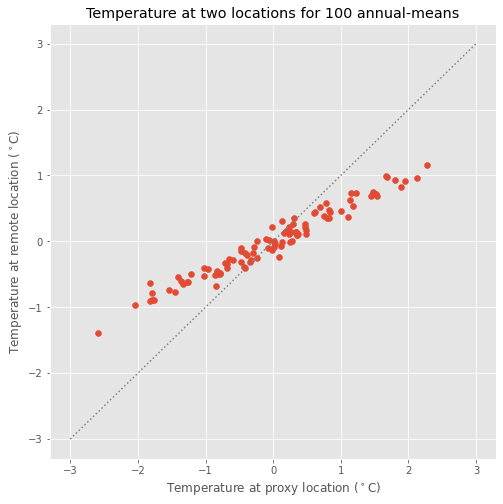

In [17]:
np.random.seed(seed=0)
tas_loc1 = np.random.normal(loc=0,scale=1,size=100)
tas_loc2 = slope_between_locations * tas_loc1

tas_loc1 = tas_loc1 + np.random.normal(loc=0,scale=noise_to_add,size=100)
tas_loc2 = tas_loc2 + np.random.normal(loc=0,scale=noise_to_add,size=100)

tas_loc1 = tas_loc1 - np.mean(tas_loc1)
tas_loc2 = tas_loc2 - np.mean(tas_loc2)

# Combine the data into a single array
Xb = np.stack((tas_loc1,tas_loc2),axis=0)
print('Prior shape:',Xb.shape)

# Compare the values at the two locations with a scatterplot
plt.figure(figsize=(8,8))
plt.scatter(Xb[0,:],Xb[1,:])
plt.plot([-3,3],[-3,3],'gray',linestyle=':')
plt.xlabel('Temperature at proxy location ($^\circ$C)')
plt.ylabel('Temperature at remote location ($^\circ$C)')
plt.title('Temperature at two locations for 100 annual-means')
plt.show()

Our prior (set above) defines two things: the inital ranges of values at each location and the relationship between the two locations. Because we want to infer climate at locations away from the proxy site, covariances between different locations is the heart of data assimiltion.

For paleoclimate data assimilatoin, we need several things:
 - The prior: **Xb**, defined above
 - Proxy data: **obvalue** and **ob_err**, defined above.
 - Model-based estimates of the proxy data: **Ye**, defined below.

The model-based estimate of the proxy will be compared to the proxy data to see if our prior is too hot or too cold. Since our "proxy" data is annual-mean temperature at our first location, the model-based estimate of the proxy (Ye) will be the same as the prior values at that location.

With all of this data, we can do the data assimilation. To better understand the method, read through the code and the outputs below. Also, consult Eq. 4a,b in Tardif et al., 2019, "Last Millennium Reanalysis with an expanded proxy database and seasonal proxy modeling"

After doing the data assimilation calculations, the code makes a figure to compare the initial temperature estimates (the prior) against the final assimilated temperature estimates (the posterior).

=== Step 1: Update the reconstruction mean.  This is Eq. 4a of Tardif et al,. 2019. ===

Covariances:                   [1.06043911 0.52686295]
Variance:                      1.0604391126934822
R:                             0
Kalman gain (cov / (var + R)): [1.        0.4968347]
Innovation:                    2.0

Notes:
------
If R is 0, the Kalman gain simplifies to cov/var, which is the slope between values at the proxy location
and each other locations. See for yourself:
Slopes:  1.0 0.4968346982580283

In other words, the Kalman gain is a scaling factor that translates anomalies at the proxy location to other
locations. Uncertainty in the proxy (R > 0) will reduce this scaling factor. R is the mean square error of the
proxy, so it has the same units as variance.

=== Step 2: Update the reconstruction spread.  This is Eq. 4b of Tardif et al,. 2019. ===

Beta:                1.0
Updated Kalman gain: [[1.        0.4968347]]

Notes:
------
The second step is to reduce the ensemble spr

C:\Users\micha\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


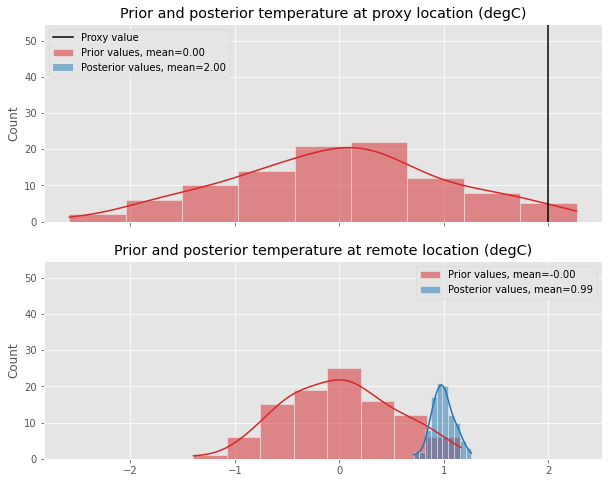

In [18]:
# Initial estimates of the value at the proxy location. 
Ye = Xb[0,:]

### Data assimiltion code adapted from the Last Millennium Reanalysis (LMR) code

# Calculate some basic values
Nens = Xb.shape[1]                 # Number of ensemble members
xbm = np.mean(Xb,axis=1)           # Prior ensemble mean
Xbp = np.subtract(Xb,xbm[:,None])  # Prior ensemble pertubations
mye   = np.mean(Ye)                # Proxy estimate mean
varye = np.var(Ye,ddof=1)          # Proxy estimate variance
ye = np.subtract(Ye, mye)          # Proxy estimate pertubations


print('=== Step 1: Update the reconstruction mean.  This is Eq. 4a of Tardif et al,. 2019. ===\n')

# innovation
innov = obvalue - mye

# innovation variance (denominator of serial Kalman gain)
kdenom = (varye + ob_err)

# numerator of serial Kalman gain (cov(x,Hx))
kcov = np.dot(Xbp,np.transpose(ye)) / (Nens-1)

# Kalman gain
kmat = np.divide(kcov, kdenom)

# update ensemble mean
xam = xbm + np.multiply(kmat,innov)

# Print some values
print('Covariances:                  ',kcov)
print('Variance:                     ',varye)
print('R:                            ',ob_err)
print('Kalman gain (cov / (var + R)):',kmat)
print('Innovation:                   ',innov)

print('\nNotes:')
print('------')
print('If R is 0, the Kalman gain simplifies to cov/var, which is the slope between values at the proxy location')
print('and each other locations. See for yourself:')
print('Slopes: ',stats.linregress(Ye,Xb[0,:])[0],stats.linregress(Ye,Xb[1,:])[0])

print('\nIn other words, the Kalman gain is a scaling factor that translates anomalies at the proxy location to other')
print('locations. Uncertainty in the proxy (R > 0) will reduce this scaling factor. R is the mean square error of the')
print('proxy, so it has the same units as variance.')


print('\n=== Step 2: Update the reconstruction spread.  This is Eq. 4b of Tardif et al,. 2019. ===\n')

# update the ensemble members using the square-root approach
beta = 1./(1. + np.sqrt(ob_err/(varye+ob_err)))
kmat = np.multiply(beta,kmat)
ye   = np.array(ye)[np.newaxis]
kmat = np.array(kmat)[np.newaxis]
Xap  = Xbp - np.dot(kmat.T, ye)

# Print some values
print('Beta:               ',beta)
print('Updated Kalman gain:',kmat)

print('\nNotes:')
print('------')
print('The second step is to reduce the ensemble spread.  If R is 0 then beta is 1, which means that each member')
print('of the ensemble is adjusted toward the mean using the original Kalman gain, similar to step 1. In the R=0 case,')
print('this will completely collapse the ensemble at the proxy location, leaving us with no uncertainty. If we have')
print('perfect confidence in the proxy, which is what we want. However, this is unrealistic, since all proxies have')
print('uncertainty. The larger the uncertainy, the less the ensemble spread is reduced.')

# full state
Xa = np.add(xam[:,None], Xap)


### FIGURE

f, ax = plt.subplots(2,1,figsize=(10,8),sharex=True,sharey=True)
ax = ax.ravel()

sns.histplot(Xb[0,:],kde=True,color='tab:red', ax=ax[0],label='Prior values, mean='+str('{:.2f}'.format(np.mean(Xb[0,:]))))
sns.histplot(Xa[0,:],kde=True,color='tab:blue',ax=ax[0],label='Posterior values, mean='+str('{:.2f}'.format(np.mean(Xa[0,:]))))
ax[0].axvline(obvalue,color='k',label='Proxy value')
ax[0].legend()
ax[0].set_title('Prior and posterior temperature at proxy location ($^\circ$C)')

sns.histplot(Xb[1,:],kde=True,color='tab:red', ax=ax[1],label='Prior values, mean='+str('{:.2f}'.format(np.mean(Xb[1,:]))))
sns.histplot(Xa[1,:],kde=True,color='tab:blue',ax=ax[1],label='Posterior values, mean='+str('{:.2f}'.format(np.mean(Xa[1,:]))))
ax[1].legend()
ax[1].set_title('Prior and posterior temperature at remote location ($^\circ$C)')

plt.show()

The data assimilation updates the mean and the ensemble spread at each location.

We can make several observations:
 - At the proxy location (upper panel), the temperaure estimates have been brought in better alignment with the data. When proxy uncertainty is zero (R=0), the posterior temperatures equal the proxy value and there is no ensemble spread.
 - The remote location has been updated as well, based on how it covaries with the original location.
 - The range of estimates is reduced according to the proxy uncertainty (at both locations) and the covariance between the two locations (for the remote location).

This example only uses two locations: the proxy location and a single remote location. In a more realistic case, there are many remote locations on a lat/lon grid. There are also many proxy records, which can be assimilated sequentially or all at once. The proxy data will not all agree perfectly, so they all "tug" the reconstruction in different ways.  The final reconstruction, therefore, is a compromise between all available proxy data based on the modeled covariances between locations.

### Experiment more

Go back to the section labeled "User-defined settings" and change one or more of the values. Before running the code, predict how you expect the results to change. Then re-run this notebook and see if your expectations are met. Think about whether the results make sense to you.